In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader
import numpy as np

In [2]:
class Matryoshka_CE_Loss(nn.Module):
    def __init__(self, relative_importance=None, **kwargs):
        super(Matryoshka_CE_Loss, self).__init__()
        self.criterion = nn.CrossEntropyLoss(**kwargs)
        self.relative_importance = relative_importance

    def forward(self, output, target):
        losses = torch.stack([self.criterion(output_i, target) for output_i in output])
        rel_importance = torch.ones_like(losses) if self.relative_importance is None else torch.as_tensor(self.relative_importance, device=losses.device).clone().detach()        
        weighted_losses = rel_importance * losses
        return weighted_losses.sum()

class MRL_Linear_Layer(nn.Module):
    def __init__(self, nesting_list, num_classes=100, efficient=False, **kwargs):
        super(MRL_Linear_Layer, self).__init__()
        self.nesting_list = nesting_list
        self.num_classes = num_classes
        self.efficient = efficient
        if self.efficient:
            self.nesting_classifier_0 = nn.Linear(nesting_list[-1], self.num_classes, **kwargs)
        else:
            for i, num_feat in enumerate(self.nesting_list):
                setattr(self, f"nesting_classifier_{i}", nn.Linear(num_feat, self.num_classes, **kwargs))

    def forward(self, x):
        nesting_logits = ()
        for i, num_feat in enumerate(self.nesting_list):
            if self.efficient:
                if self.nesting_classifier_0.bias is None:
                    nesting_logits += (torch.matmul(x[:, :num_feat], (self.nesting_classifier_0.weight[:, :num_feat]).t()), )
                else:
                    nesting_logits += (torch.matmul(x[:, :num_feat], (self.nesting_classifier_0.weight[:, :num_feat]).t()) + self.nesting_classifier_0.bias, )
            else:
                nesting_logits += (getattr(self, f"nesting_classifier_{i}")(x[:, :num_feat]),)
        return nesting_logits
        

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [4]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

train_set = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test_set = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=1)
test_loader = DataLoader(test_set, batch_size=100, shuffle=False, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# тут меняется размер фиксированного слоя
nesting_list = [8]
relative_importance = [1.0]
relative_importance_tensor = torch.tensor(relative_importance, device=device)
model = resnet18(weights=None)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.fc = MRL_Linear_Layer(nesting_list, num_classes=100, efficient=False)
model = model.to(device)

In [6]:
def train(epoch):
    model.train()
    train_loss = 0
    correct = {n: 0 for n in nesting_list}
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        for i, n in enumerate(nesting_list):
            _, predicted = outputs[i].max(1)
            correct[n] += predicted.eq(targets).sum().item()
        total += targets.size(0)

    avg_acc = 100. * sum(correct.values()) / (total * len(nesting_list))
    print(f"| {'Train':^6} {epoch:^3} | Loss: {train_loss/((batch_idx+1) * len(nesting_list)):^7.3f} | Acc: {avg_acc:^6.3f}% |")

In [7]:
def test(epoch):
    model.eval()
    test_loss = 0
    correct_top1 = {n: 0 for n in nesting_list}
    correct_top5 = {n: 0 for n in nesting_list}
    total = 0
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            
            for i, n in enumerate(nesting_list):
                _, predicted = outputs[i].max(1)
                correct_top1[n] += predicted.eq(targets).sum().item()
                
                _, top5_pred = outputs[i].topk(5, 1, True, True)
                correct_top5[n] += top5_pred.eq(targets.view(-1, 1)).sum().item()
            
            total += targets.size(0)

    avg_top1 = sum(100. * correct_top1[n] / total for n in nesting_list) / len(nesting_list)
    avg_top5 = sum(100. * correct_top5[n] / total for n in nesting_list) / len(nesting_list)
    
    print("\n┌──────────┬────────────┬────────────┐")
    print(f"│ {'Size':^8} │ {'Top-1 Acc':^10} │ {'Top-5 Acc':^10} │")
    print("├──────────┼────────────┼────────────┤")
    
    for n in nesting_list:
        top1 = 100. * correct_top1[n] / total
        top5 = 100. * correct_top5[n] / total
        print(f"│ {n:^8} │ {top1:>9.2f}% │ {top5:>9.2f}% │")
    
    print("├──────────┼────────────┼────────────┤")
    print(f"│ {'Average':^8} │ {avg_top1:>9.2f}% │ {avg_top5:>9.2f}% │")
    print("└──────────┴────────────┴────────────┘")
    
    return avg_top1 

In [8]:
criterion = Matryoshka_CE_Loss(relative_importance=relative_importance_tensor)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

| Train   0  | Loss:  4.071  | Acc: 6.740 % |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     10.06% │     33.23% │
├──────────┼────────────┼────────────┤
│ Average  │     10.06% │     33.23% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:18
--------------------------------------------------------------------------------
| Train   1  | Loss:  3.565  | Acc: 13.544% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     15.52% │     43.28% │
├──────────┼────────────┼────────────┤
│ Average  │     15.52% │     43.28% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:18
--------------------------------------------------------------------------------
| Train   2  | Loss:  3.274  | Acc: 18.034% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────

| Train  20  | Loss:  2.145  | Acc: 43.766% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     39.27% │     70.56% │
├──────────┼────────────┼────────────┤
│ Average  │     39.27% │     70.56% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:18
--------------------------------------------------------------------------------
| Train  21  | Loss:  2.124  | Acc: 44.056% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     40.81% │     70.86% │
├──────────┼────────────┼────────────┤
│ Average  │     40.81% │     70.86% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:18
--------------------------------------------------------------------------------
| Train  22  | Loss:  2.115  | Acc: 44.168% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────

| Train  40  | Loss:  1.932  | Acc: 49.400% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     45.52% │     73.54% │
├──────────┼────────────┼────────────┤
│ Average  │     45.52% │     73.54% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:18
--------------------------------------------------------------------------------
| Train  41  | Loss:  1.926  | Acc: 49.672% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     46.40% │     73.99% │
├──────────┼────────────┼────────────┤
│ Average  │     46.40% │     73.99% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:18
--------------------------------------------------------------------------------
| Train  42  | Loss:  1.926  | Acc: 49.284% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────

| Train  60  | Loss:  1.791  | Acc: 53.216% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     47.26% │     74.61% │
├──────────┼────────────┼────────────┤
│ Average  │     47.26% │     74.61% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:18
--------------------------------------------------------------------------------
| Train  61  | Loss:  1.787  | Acc: 53.042% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     46.82% │     74.90% │
├──────────┼────────────┼────────────┤
│ Average  │     46.82% │     74.90% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:18
--------------------------------------------------------------------------------
| Train  62  | Loss:  1.780  | Acc: 53.496% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────

| Train  80  | Loss:  1.632  | Acc: 57.002% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     51.40% │     76.94% │
├──────────┼────────────┼────────────┤
│ Average  │     51.40% │     76.94% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:18
--------------------------------------------------------------------------------
| Train  81  | Loss:  1.626  | Acc: 57.094% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     48.22% │     74.32% │
├──────────┼────────────┼────────────┤
│ Average  │     48.22% │     74.32% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:18
--------------------------------------------------------------------------------
| Train  82  | Loss:  1.623  | Acc: 57.338% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────

| Train  100 | Loss:  1.426  | Acc: 62.030% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     56.35% │     81.16% │
├──────────┼────────────┼────────────┤
│ Average  │     56.35% │     81.16% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:18
--------------------------------------------------------------------------------
| Train  101 | Loss:  1.422  | Acc: 62.344% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     55.66% │     81.25% │
├──────────┼────────────┼────────────┤
│ Average  │     55.66% │     81.25% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:18
--------------------------------------------------------------------------------
| Train  102 | Loss:  1.404  | Acc: 62.556% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────

| Train  120 | Loss:  1.171  | Acc: 68.652% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     58.96% │     81.46% │
├──────────┼────────────┼────────────┤
│ Average  │     58.96% │     81.46% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:18
--------------------------------------------------------------------------------
| Train  121 | Loss:  1.153  | Acc: 68.772% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     57.26% │     81.08% │
├──────────┼────────────┼────────────┤
│ Average  │     57.26% │     81.08% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:18
--------------------------------------------------------------------------------
| Train  122 | Loss:  1.140  | Acc: 69.316% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────

| Train  140 | Loss:  0.823  | Acc: 77.112% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     61.31% │     82.80% │
├──────────┼────────────┼────────────┤
│ Average  │     61.31% │     82.80% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:18
--------------------------------------------------------------------------------
| Train  141 | Loss:  0.802  | Acc: 77.722% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     63.42% │     83.84% │
├──────────┼────────────┼────────────┤
│ Average  │     63.42% │     83.84% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:18
--------------------------------------------------------------------------------
| Train  142 | Loss:  0.770  | Acc: 78.370% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────

| Train  160 | Loss:  0.384  | Acc: 88.898% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     65.56% │     85.00% │
├──────────┼────────────┼────────────┤
│ Average  │     65.56% │     85.00% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:18
--------------------------------------------------------------------------------
| Train  161 | Loss:  0.358  | Acc: 89.774% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     65.17% │     84.52% │
├──────────┼────────────┼────────────┤
│ Average  │     65.17% │     84.52% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:18
--------------------------------------------------------------------------------
| Train  162 | Loss:  0.347  | Acc: 89.980% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────

| Train  180 | Loss:  0.072  | Acc: 98.286% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     69.40% │     85.77% │
├──────────┼────────────┼────────────┤
│ Average  │     69.40% │     85.77% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:18
--------------------------------------------------------------------------------
| Train  181 | Loss:  0.065  | Acc: 98.510% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     69.22% │     85.87% │
├──────────┼────────────┼────────────┤
│ Average  │     69.22% │     85.87% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:18
--------------------------------------------------------------------------------
| Train  182 | Loss:  0.061  | Acc: 98.660% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────

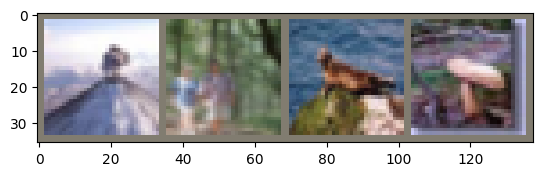

GroundTruth:	 49	33	72	51
Size		Image 1	Image 2	Image 3	Image 4
8		12	33	93	51


In [9]:
import time
from datetime import timedelta

total_start_time = time.time()
epoch_times = []

best_acc = 0
for epoch in range(200):
    epoch_start = time.time()
    train(epoch)
    acc = test(epoch)
    scheduler.step()
    
    epoch_time = time.time() - epoch_start
    epoch_times.append(epoch_time)

    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), 'best_model_mrl_8.pth')
    print(f'Epoch time: {timedelta(seconds=int(epoch_time))}')
    print('-' * 80)

total_time = time.time() - total_start_time
print(f'Total training time: {timedelta(seconds=int(total_time))}')
print(f'Average epoch time: {timedelta(seconds=int(sum(epoch_times)/len(epoch_times)))}')    

print(f'Best Test Accuracy: {best_acc:.2f}%')

import matplotlib.pyplot as plt
def imshow(img):
    img = img * torch.tensor([0.2675, 0.2565, 0.2761]).view(3, 1, 1) + \
          torch.tensor([0.5071, 0.4867, 0.4408]).view(3, 1, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth:\t', '\t'.join(f'{labels[j]}' for j in range(4)))

print("Size\t\t" + "\t".join(f"Image {j+1}" for j in range(4)))
outputs = model(images[:4].to(device))
for i, n in enumerate(nesting_list):
    _, predicted = torch.max(outputs[i], 1)
    print(f"{n}\t\t" + "\t".join(f"{predicted[j].item()}" for j in range(4)))